In [ ]:
# default_exp football 

# Football Data Science

> explore and practice on the open data provided by [StatsBomb](https://statsbomb.com/)

## content
- pandas munging
- EDA visuals

see also: https://github.com/dietofworms/football-science/tree/master/code

In [15]:
# export
import numpy as np
import pandas as pd
import os
import json
from functools import reduce

In [2]:
# get all files in directory
def get_files(path):
    x = os.listdir(path)
    return [os.path.splitext(i)[0] for i in x] 

In [ ]:
# path = 'events/'
# data_id = get_files(path)

# # read the json files and concatenate into a dataframe
# all_korea = pd.DataFrame()
# for i in data_id:
#     with open(path + str(i) + '.json') as data_file:
#         data = json.load(data_file)
#     df = pd.json_normalize(data, sep = '_')
#     if all_korea.empty:
#         all_korea = df
#     else:
#         all_korea = pd.concat([all_korea, df], join = 'outer', sort = False)

In [12]:
# all_korea.to_parquet('all_korea.parquet', compression='gzip')
all_korea = pd.DataFrame()

In [30]:
all_korea.head()

,id,index,period,timestamp,minute,second,possession,off_camera,duration,type_id,...,pass_miscommunication,block_offensive,50_50_outcome_id,50_50_outcome_name,clearance_aerial_won,shot_deflected,shot_open_goal,miscontrol_aerial_won,block_save_block,shot_redirect
0,8671703e-aab7-47a8-818e-a83a91278658,1,1,00:00:00.000,0,0,1,False,0.00,35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,08a66b27-7098-4396-b942-ba73fa2e2df6,2,1,00:00:00.000,0,0,1,False,0.00,35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48b94b06-ebbd-47e9-958c-44bf63622f5e,3,1,00:00:00.000,0,0,1,False,8.16,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,c771a4d4-51cb-41de-83aa-7103cd199c92,4,1,00:00:00.000,0,0,1,False,7.96,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,272ef47d-171f-4395-a156-f4979e7bf352,5,1,00:00:00.100,0,0,2,False,0.00,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# count total number of dribble
total_dribble = all_korea.groupby('player_name')['type_name'].apply(lambda x:(x=='Dribble').sum()).reset_index(name='total_dribble')

# number of dribble completed
dribble_complete = all_korea.groupby('player_name')['dribble_outcome_name'].apply(lambda x: (x=='Complete').sum()).reset_index(name='dribble_completed')

# total number of pass
total_pass = all_korea.groupby('player_name')['type_name'].apply(lambda x: (x=='Pass').sum()).reset_index(name='total_pass')

# number of incomplete pass
pass_incomplete = all_korea.groupby('player_name')['pass_outcome_name'].count().reset_index(name='incomplete_pass')

# number of times being dispossessed
dispossessed = all_korea.groupby('player_name')['type_name'].apply(lambda x: (x=='Dispossessed').sum()).reset_index(name='dispossessed')


In [16]:
df_list = [total_dribble,
           dribble_complete,
           total_pass,
           pass_incomplete,
           dispossessed]

summary_data = reduce(lambda x,y : pd.merge(x,y, on = 'player_name'), df_list)

summary_data.head()

,player_name,total_dribble,dribble_completed,total_pass,incomplete_pass,dispossessed
0,Aaron Mooy,1,1,206,38,2
1,Abbie McManus,0,0,46,10,0
2,Abby Dahlkemper,0,0,417,93,0
3,Abby Erceg,0,0,472,90,1
4,Abby Smith,0,0,181,68,0


# Modeling
From the above exploratory data analysis, we noticed many incomplete passes are quite long. This lead me to question the relationship between the length of pass and the chance that is would be incomplete. Since the problem is not determining a continuous quantitative outcome but rather a discrete binary outcome, we will use clustering.

In [19]:
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

Preparing the data by manipulating from the raw format into a manageable data frame.

In [20]:
# get pass length and the outcome
passing_set = all_korea[['pass_length', 
                         'duration', 
                         'pass_angle',
                         'pass_height_id',
                         'pass_height_name',
                         'pass_outcome_name']]

pass_length_outcome = all_korea[['pass_length', 
                                 'duration', 
                                 'pass_angle',
                                 'pass_height_id',
                                 'pass_height_name',
                                 'pass_outcome_name']]

# remove pass lengths <= 0 
pass_length_outcome = pass_length_outcome[pass_length_outcome['pass_length']>0]

# make NaNs = 1 (complete pass)
pass_length_outcome['pass_outcome_name'] = pass_length_outcome['pass_outcome_name'].fillna(1)

# convert outcomes to 0/1 indicating fail or success
pass_length_outcome['pass_outcome_name'] = pass_length_outcome['pass_outcome_name'].map(lambda x: 1 if x==1 else 0)

# cast pass_height_id to int
pass_length_outcome['pass_height_id'] = pass_length_outcome['pass_height_id'].astype(int)

In [21]:
pass_length_outcome.head()

,pass_length,duration,pass_angle,pass_height_id,pass_height_name,pass_outcome_name
4,3.605551,0.000,-0.982794,1,Ground Pass,1
7,31.764761,1.640,-1.078987,2,Low Pass,1
12,59.033890,2.587,0.456072,3,High Pass,0
13,18.110771,1.173,-0.110657,3,High Pass,0
16,2.828427,0.147,0.785398,3,High Pass,0


# Exploratory Data Analysis
Now that we have a clean dataset, let's perform some EDA. We will begin with visualising in multiple plots.



<AxesSubplot:xlabel='pass_height_name', ylabel='count'>

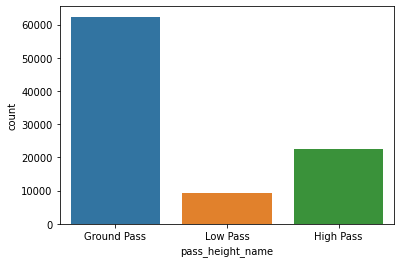

In [22]:
import seaborn as sns

sns.countplot(pass_length_outcome['pass_height_name'],label="Count")
# <!-- plt.show() -->

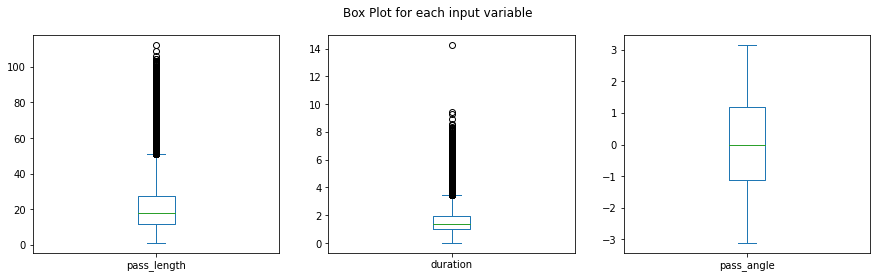

In [24]:
pass_input_variables = pass_length_outcome[['pass_length','duration','pass_angle']]

pass_input_variables.plot(kind='box',
                          subplots=True,
                          layout=(1,3),
                          sharex=False,
                          figsize=(15,4),
                          title='Box Plot for each input variable');

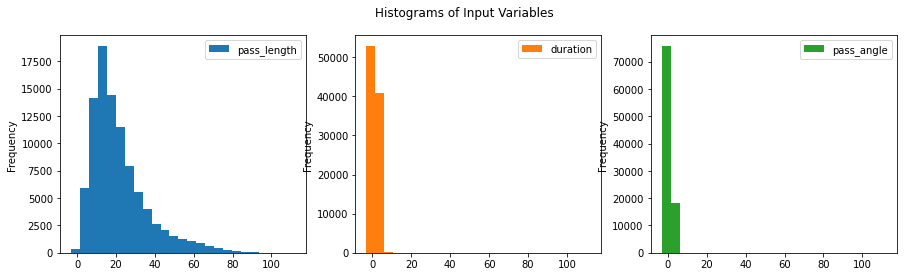

In [27]:
import pylab as pl

pass_input_variables.plot(kind='hist',
                          subplots=True,
                          bins=25,
                          sharex=False,
                          layout=(1,3),
                          figsize=(15,4))
pl.suptitle("Histograms of Input Variables");
# plt.show()


NameError: name 'plt' is not defined

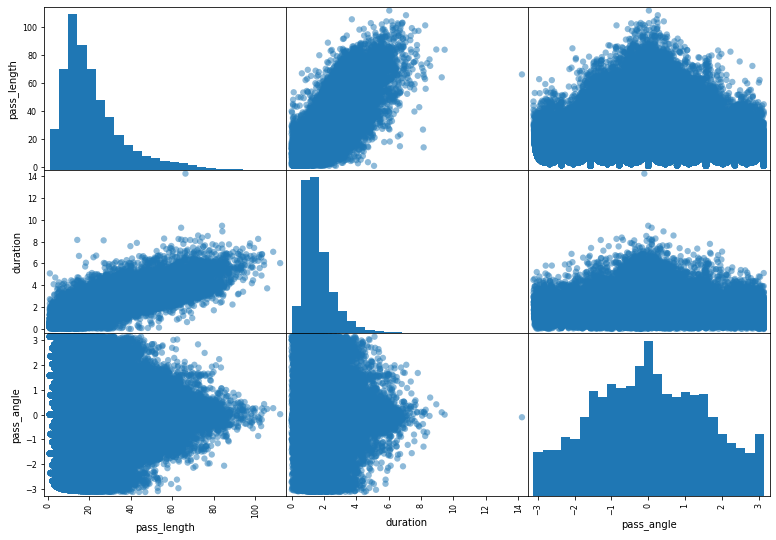

In [28]:
from pandas.plotting import scatter_matrix
from matplotlib import cm

feature_names = list(pass_input_variables.columns)
X = pass_length_outcome[feature_names]
y = list(pass_length_outcome['pass_height_name'].unique())

cmap = cm.get_cmap('gnuplot')
scatter = scatter_matrix(X, marker = 'o', s = 40, 
                            hist_kwds = {'bins' : 25},
                            figsize = (13,9),
                            cmap = cmap)
plt.suptitle('Scatter Matrix of Input Variables')

In [29]:
pass_input_variables.describe()

,pass_length,duration,pass_angle
count,94119.000000,94119.000000,94119.000000
mean,21.526914,1.593622,0.021612
std,14.622941,0.927950,1.526225
min,1.000000,0.000000,-3.120319
25%,11.401754,0.973000,-1.128422
50%,17.691807,1.360000,0.000000
75%,27.294687,1.973000,1.180639
max,112.017850,14.232000,3.141593
